In [1]:
import torch
from typing import List, Tuple, Any, Optional

HiddenT = torch.tensor  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]


class FeedForward(torch.nn.Module):
    """
    Inputs a tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]
    and processes it as follows:
    * project linearly from hidden_dim to inner_dim
    * apply activation function (GELU)
    * project linearly from inner_dim to hidden_dim
    """

    def __init__(self, hidden_dim: int, inner_dim: int) -> None:
        super().__init__()

        self.linear1 = torch.nn.Linear(hidden_dim, inner_dim)
        self.activation = torch.nn.GELU()
        self.linear2 = torch.nn.Linear(inner_dim, hidden_dim)

    def forward(self, x: HiddenT) -> HiddenT:
        # [BATCH, SEQ_LEN, HIDDEN_DIM]
        assert len(x.shape) == 3

        x = self.linear1(x)
        x = self.activation(x)
        result = self.linear2(x)

        # [BATCH, SEQ_LEN, HIDDEN_DIM]
        assert len(result.shape) == 3
        return result


##### TESTS START #####

def test_ff():
    def test_grad_and_shapes():
        feed_forward = FeedForward(16, 32)
        assert len(list(feed_forward.parameters())) >= 1
        x = torch.rand(3, 5, 16, requires_grad=True)
        y = feed_forward(x)
        assert x.shape == y.shape
        loss = y.sum()
        loss.backward()
        assert x.grad is not None

    test_grad_and_shapes()


test_ff()

#####  TESTS END  #####

In [2]:
AttentionT = torch.tensor  # torch tensor of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]


class AttentionCreateQKV(torch.nn.Module):
    """
    Given a tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]
    uses linear projections to create three tensors
    Query, Key and Value.
    Each of the created tensors has shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM].
    Where HEAD_DIM = HIDDEN_DIM // NUM_HEADS
    """

    def __init__(self, hidden_dim, num_heads) -> None:
        super().__init__()
        assert hidden_dim % num_heads == 0
        self.head_dim = hidden_dim // num_heads
        self.num_heads = num_heads

        self.query_linear = torch.nn.Linear(hidden_dim, hidden_dim)
        self.key_linear = torch.nn.Linear(hidden_dim, hidden_dim)
        self.value_linear = torch.nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x: HiddenT) -> Tuple[AttentionT, AttentionT, AttentionT]:
        assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

        BATCH = x.size(0)
        SEQ_LEN = x.size(1)

        Q = self.query_linear(x)
        Q = Q.view(BATCH, SEQ_LEN, self.num_heads, self.head_dim)

        K = self.key_linear(x)
        K = K.view(BATCH, SEQ_LEN, self.num_heads, self.head_dim)

        V = self.value_linear(x)
        V = V.view(BATCH, SEQ_LEN, self.num_heads, self.head_dim)

        result = [Q, K, V]

        assert len(result) == 3  # queries, keys, values
        for r in result:
            assert len(r.shape) == 4  # [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]
            assert r.shape[-2:] == (self.num_heads, self.head_dim)
            assert r.shape[:-2] == x.shape[:2]

        return result


##### TESTS START #####

def test_attn_create_qkv():
    def test_shapes():
        hidden_dim = 16
        num_heads = 8
        l = AttentionCreateQKV(hidden_dim=hidden_dim, num_heads=num_heads)
        x = torch.ones(3, 5, hidden_dim)
        ys = l(x)
        assert len(ys) == 3
        for y in ys:
            assert y.shape == x.shape[:-1] + (num_heads, hidden_dim // num_heads)

    test_shapes()

test_attn_create_qkv()

#####  TESTS END  #####

In [3]:
class RoPEPosEncoding(torch.nn.Module):
    """
    Given a tensor of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]
    applies Rotary Positional Encoding.
    offset allows to apply rotary to sequnce part by part by telling how much tokens preecede the input in the sequence.
    """

    def __init__(self, head_dim, theta) -> None:
        super().__init__()

        assert head_dim % 2 == 0
        self.hidden_dim = head_dim

        self.theta = theta
        self.register_buffer("angles", torch.pow(1 / self.theta, 2 * torch.arange(self.hidden_dim // 2).float() / self.hidden_dim))

    def forward(self, x: AttentionT, offset: int = 0):
        assert (
            len(x.shape) == 4
        )  # torch tensor of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]
        assert offset >= 0

        BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM = x.shape

        position_indices = torch.arange(SEQ_LEN, device=x.device).unsqueeze(1)
        angles = self.angles * (position_indices + offset)  # torch tensor of shape [SEQ_LEN, HEAD_DIM // 2]

        sines = torch.sin(angles)
        cosines = torch.cos(angles)
        x_paired = x.view(BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM // 2, 2)

        cosines = cosines.view(1, SEQ_LEN, 1, HEAD_DIM // 2)
        sines = sines.view(1, SEQ_LEN, 1, HEAD_DIM // 2)

        x_rotated_fst = cosines * x_paired[..., 0] - sines * x_paired[..., 1]
        x_rotated_snd = sines * x_paired[..., 0] + cosines * x_paired[..., 1]

        result = torch.stack([x_rotated_fst, x_rotated_snd], dim=-1)

        result = result.view(BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM)

        assert result.shape == x.shape

        return result


##### TESTS START #####

def test_RoPE():
    def test_offset():
        rope = RoPEPosEncoding(16, 10000)
        x = torch.ones(1, 11, 3, 16)
        y = rope(x, offset=0)
        z = rope(x, offset=2)

        assert (torch.abs(z[:, :-2] - y[:, 2:])).sum() <= 1e-4
        assert (torch.abs(z[:, :2] - y[:, :2])).sum() >= 1e-4

    def test_initial_rotation():
        rope = RoPEPosEncoding(16, 10000)
        x = torch.ones(1, 11, 3, 16)
        y = rope(x, offset=0)

        assert (torch.abs(y[:, 0] - x[:, 0])).sum() <= 1e-4

    test_offset()
    test_initial_rotation()

test_RoPE()

#####  TESTS END  #####

In [4]:
ACacheT = Tuple[
    torch.tensor, torch.tensor
]  # key, value, both of shape [BATCH, SEQ_LEN, NUM_HEADS, HEAD_DIM]

import math
class Attention(torch.nn.Module):
    """
    Implements multi-head attention layer.
    Inputs tensor x of shape [BATCH, SEQ_LEN, hidden_dim].
    Uses head_proj to create three tensors q, k, v - each of shape
    [BATCH, SEQ_LEN, num_heads, head_dim].
    Then applies RoPE to q and k.
    Then calculates attention within each head, concatenates the results
    and linearly projects them to a tensor of shape [BATCH, SEQ_LEN, hidden_dim].

    Cache is a tuple of keys (kc) and values (vc) calculated in previous calls.
    For training the cache will be empty (tensors kc and vc should have shape [BATCH, 0, num_heads, hidden_dim]),
    For efficient generation, the cache will contain keys (kc), values (vc) of already read/generated tokens
    (this allows the generation of one additional token without recomputing the keys and values for all preceding tokens).
    After RoPE application to k, kc and vc are prepended to k and v respectively.

    The model outputs the linearly projected output of attention along with a cache extended with new keys and values.
    """
    def __init__(
        self, hidden_dim: int, num_heads: int, head_proj=AttentionCreateQKV
    ) -> None:
        super().__init__()

        assert hidden_dim % num_heads == 0

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        self.head_proj = head_proj(hidden_dim, num_heads)
        self.q_rope = RoPEPosEncoding(self.head_dim, 10000)
        self.k_rope = RoPEPosEncoding(self.head_dim, 10000)
        self.out_proj = torch.nn.Linear(hidden_dim, hidden_dim)

    def get_empty_cache(self, batch_size: int, device) -> ACacheT:
        return torch.empty(
            batch_size, 0, self.num_heads, self.head_dim, device=device
        ), torch.empty(batch_size, 0, self.num_heads, self.head_dim, device=device)

    def forward(self, x: HiddenT, cache: ACacheT) -> HiddenT:
        assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

        BATCH, SEQ_LEN, HIDDEN_DIM = x.size()

        Q,K,V = self.head_proj(x)
        Q = Q.view(BATCH, SEQ_LEN, self.num_heads, self.head_dim)
        K = K.view(BATCH, SEQ_LEN, self.num_heads, self.head_dim)
        V = V.view(BATCH, SEQ_LEN, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_rope(K).transpose(1, 2)
        Q = self.q_rope(Q).transpose(1, 2)

        attention_scores = torch.matmul(Q, K.transpose(2, 3)) / math.sqrt(self.head_dim)

        mask = torch.tril(torch.ones(SEQ_LEN, SEQ_LEN, device=x.device), diagonal=0).bool()
        attention_scores.masked_fill_(~mask, float('-inf'))

        attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_weights, V)

        attention_output = attention_output.transpose(1, 2).contiguous().view(BATCH, SEQ_LEN, -1)
        attention = self.out_proj(attention_output)

        return attention, attention_weights, cache


def test_attention():
    def test_shapes():
        num_heads = 8
        hidden_dim = 16
        attn_layer = Attention(hidden_dim, num_heads)
        x = torch.ones(2, 5, hidden_dim)
        y, attn_w, _ = attn_layer(
            x, attn_layer.get_empty_cache(2, torch.device("cpu"))
        )

        assert y.shape == x.shape
        assert attn_w.shape == y.shape[:-2] + (num_heads, y.shape[-2], y.shape[-2])

    def test_attention_masking():
        num_heads = 8
        hidden_dim = 16
        attn_layer = Attention(hidden_dim, num_heads)
        x = torch.ones(2, 5, hidden_dim)
        y, attn_w, cache = attn_layer(
            x, attn_layer.get_empty_cache(2, torch.device("cpu"))
        )

        assert (attn_w < 0).sum() <= 1e-4

        assert (torch.triu(torch.ones(5, 5), diagonal=1) * attn_w).sum() <= 1e-4

    test_shapes()
    test_attention_masking()


test_attention()

#####  TESTS END  #####

In [5]:
class LayerNorm(torch.nn.Module):
    def __init__(self, hidden_dim, eps=1e-05) -> None:
        super().__init__()

        self.hidden_dim = hidden_dim
        self.eps = eps

        self.gamma = torch.nn.Parameter(torch.ones(hidden_dim))
        self.beta = torch.nn.Parameter(torch.zeros(hidden_dim))

    def forward(self, x: HiddenT) -> HiddenT:
        assert len(x.shape) == 3  # torch tensor of shape [BATCH, SEQ_LEN, HIDDEN_DIM]

        mean = torch.mean(x,-1).unsqueeze(-1)
        dev = torch.sqrt(torch.var(x,-1, unbiased=False) + self.eps).unsqueeze(-1)

        result = (x - mean) / dev * self.gamma + self.beta

        assert x.shape == result.shape
        return result


##### TESTS START #####

def test_layer_norm():

    @torch.no_grad
    def test_initial_norm():
        ln = LayerNorm(16)
        x = torch.rand((3, 5, 16))
        normalized = ln(x)
        assert torch.abs(torch.mean(normalized, dim=-1)).mean()  <= 1e-4
        assert torch.abs(torch.std(normalized, dim=-1, unbiased=False).mean() - 1) <= 1e-2


    def test_rising_norm():
        ln = LayerNorm(16)
        x = torch.rand((3, 5, 16))
        initial_norm = torch.sqrt((ln(x) ** 2).sum(dim=-1))

        optim = torch.optim.AdamW(ln.parameters(), lr=10)

        for i in range(100):
            optim.zero_grad()
            norm = torch.sqrt((ln(x) ** 2).sum(dim=-1))
            loss = -norm.mean()
            loss.backward()
            optim.step()

        final_norm = torch.sqrt((ln(x) ** 2).sum(dim=-1))
        assert final_norm.mean() - initial_norm.mean() > 100.0


    test_initial_norm()
    test_rising_norm()

test_layer_norm()

#####  TESTS END  #####

In [6]:
class TransformerBlock(torch.nn.Module):
    def __init__(self, hidden_dim, ff_dim, num_heads) -> None:
        """
        ff_dim - internal dimension of feed_forward.
        num_heads - num attention heads
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        self.norm1 = LayerNorm(hidden_dim)
        self.attention = Attention(hidden_dim, num_heads)
        self.norm2 = LayerNorm(hidden_dim)
        self.feed_forward = FeedForward(hidden_dim, ff_dim)

    def get_empty_cache(self, batch_size: int, device):
        return self.attention.get_empty_cache(batch_size=batch_size, device=device)

    def forward(self, x: HiddenT, attn_cache: ACacheT) -> Tuple[HiddenT, ACacheT]:
        y = self.norm1(x)
        y,_, _ = self.attention(y, None)
        y = y + x
        z = self.norm2(y)
        z = self.feed_forward(z)
        result =  z + y
        cache = None

        assert x.shape == result.shape

        return result, cache

In [7]:

TokensT = torch.tensor # [BATCH, SEQ_LEN]
ModelLT = torch.tensor # [BATCH, SEQ_LEN, VOCAB_SIZE]
class Transformer(torch.nn.Module):
    def __init__(self, vocab_size: int, n_layers: int, hidden_dim: int, ff_dim: int, num_heads: int) -> None:
        super().__init__()

        self.vocab_size = vocab_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads

        self.embedding = torch.nn.Embedding(vocab_size, hidden_dim)

        self.layers = torch.nn.ModuleList([
            TransformerBlock(hidden_dim=hidden_dim, ff_dim=ff_dim, num_heads=num_heads) for _ in range(n_layers)
        ])

        self.final_proj = torch.nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: TokensT, cache : Optional[List[ACacheT]] = None) -> Tuple[ModelLT, List[ACacheT]]:
        assert len(x.shape) == 2 # [BATCH, SEQ_LEN]
        assert cache is None or len(cache) == self.n_layers

        if cache is None:
            cache = [l.get_empty_cache(x.shape[0], x.device) for l in self.layers]

        x = self.embedding(x)

        new_cache = []

        for l, c in zip(self.layers, cache):
            x, c = l(x, attn_cache=c)
            new_cache.append(c)

        x = self.final_proj(x)
        return x, new_cache

def test_transformer():

    def test_run():
        transformer = Transformer(16, 4, 32, 64, 4)
        x = torch.tensor([[1, 2, 3]])
        transformer(x)

    def test_device():
        transformer = Transformer(16, 4, 32, 64, 4)
        x = torch.tensor([[1, 2, 3]]).to(torch.device("cpu"))
        transformer.to(torch.device("cpu"))
        transformer(x)

    test_run()
    test_device()

test_transformer()

In [8]:
import numpy as np

def generate_recursive(n_first, vocab_size, next_prob):
    assert 0 < vocab_size
    initial = np.random.randint(0, vocab_size, n_first)
    coeffs = np.random.randint(0, vocab_size, n_first)

    return initial, coeffs, vocab_size, next_prob

class SeqGen:
    """
    For generating recurrent sequences with stochastically repeating terms.
    """
    def __init__(self, initial, coeffs, size, next_prob):
        assert len(coeffs) == len(initial)
        self.initial = initial
        self.coeffs = coeffs
        self.size = size
        self.next_prob = next_prob

        self.current = initial

    def __iter__(self):
        return self

    def __next__(self):
        if np.random.random() < self.next_prob:
          new = self.current[-1] + 1
        else:
          new = (self.current @ self.coeffs)

        new %= self.size
        self.current = np.append(self.current, new)[1:]

        return new

    def __key(self):
        return (tuple(self.initial), tuple(self.coeffs), self.size, self.next_prob)

    def __hash__(self):
        return hash(self.__key())

    def __eq__(self, other):
        if isinstance(other, SeqGen):
            return self.__key() == other.__key()


def generate_dataset(gen_factory, seq_len, num_entries, exclude = []):
    """
    For generating datasets with num_entries elements each
    of length seq_len.

      gen_factory is a procedure that returns
        instance of SeqGen when called.

      seq_len is the length of the sequence to generate.

      num_entries is the number of sequences to generate.

      exclude is the set of sequences that aren't to be used in training
    """
    entries = []
    generators = []
    for e in range(num_entries):
        while True:
          seq_gen = gen_factory()
          if seq_gen in exclude:
              continue

          seq = []
          for s in range(seq_len + 1):
              seq.append(next(seq_gen))

          break

        generators.append(seq_gen)
        entries.append(seq)
    data = torch.tensor(entries, dtype=torch.long)
    x = data[:, :seq_len]
    y = data[:, 1:]       # we predict next token
    return torch.utils.data.TensorDataset(x, y), set(generators)


In [9]:
def example_generator(gen):
    """
      A procedure that returns a representation of
      a single data entrance.
    """
    def example_gen():
        return SeqGen(*gen())
    return example_gen

In [10]:
BATCH_SIZE = 128
SEQ_LEN = 64


VOCAB_SIZE = 7
NEXT_PROB = .1
INITIAL = 2


DEVICE = torch.device("cuda")
#DEVICE = torch.device("cpu")
PERM_EXAMPLE_GENERATOR = example_generator(lambda: generate_recursive(INITIAL, VOCAB_SIZE, NEXT_PROB))


TEST_DATASET, generators = generate_dataset(
    gen_factory=PERM_EXAMPLE_GENERATOR, seq_len=SEQ_LEN, num_entries=1000)
TRAIN_DATASET, _ = generate_dataset(
    gen_factory=PERM_EXAMPLE_GENERATOR, seq_len=SEQ_LEN, num_entries=10000, exclude=generators)


TRAIN_LOADER = torch.utils.data.DataLoader(
    TRAIN_DATASET, batch_size=BATCH_SIZE)
TEST_LOADER = torch.utils.data.DataLoader(TEST_DATASET, batch_size=BATCH_SIZE)

In [11]:
from tqdm import tqdm
import functools


@torch.no_grad
def eval_acc(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    model.eval()
    sum_acc = 0
    num_examples = 0
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        model_out, _ = model(x)

        acc = (torch.argmax(model_out, dim=-1) == y).to(torch.float32).sum()
        sum_acc += acc
        num_examples += model_out.shape[0] * model_out.shape[1]

    return sum_acc / num_examples


def eval_fn(step, model, dataloader):
    acc = eval_acc(model, dataloader)
    print(f"{step}: Avg eval accuracy {acc}")


def train(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    dataloader: torch.utils.data.DataLoader,
    eval_fn,
):
    model.train()

    for epoch in range(8):
        if epoch == 0:
            eval_fn(epoch, model)

        for i, (x, y) in tqdm(enumerate(dataloader)):
            model.zero_grad()

            res, _ = model(x)

            loss_fn = torch.nn.CrossEntropyLoss()
            loss = loss_fn(res.view(-1, VOCAB_SIZE), y.view(-1))

            loss.backward()
            optimizer.step()

        eval_fn(epoch, model)


model = Transformer(
    vocab_size=VOCAB_SIZE, n_layers=4, hidden_dim=64, ff_dim=128, num_heads=4
)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
train(
    model=model,
    optimizer=optimizer,
    dataloader=TRAIN_LOADER,
    eval_fn=functools.partial(
        eval_fn,
        dataloader=TEST_LOADER,
    ),
)

0: Avg eval accuracy 0.14079686999320984


79it [00:39,  1.98it/s]


0: Avg eval accuracy 0.47151562571525574


79it [00:39,  1.98it/s]


1: Avg eval accuracy 0.6825312376022339


79it [00:39,  1.99it/s]


2: Avg eval accuracy 0.747671902179718


79it [00:40,  1.95it/s]


3: Avg eval accuracy 0.775515615940094


79it [00:39,  1.99it/s]


4: Avg eval accuracy 0.7870156168937683


79it [00:39,  1.99it/s]


5: Avg eval accuracy 0.7970156073570251


79it [00:39,  1.98it/s]


6: Avg eval accuracy 0.8039844036102295


79it [00:39,  2.00it/s]


7: Avg eval accuracy 0.8125468492507935


In [13]:
@torch.no_grad
def token_choice_greedy(model_logits: ModelLT):
    assert len(model_logits.shape) == 3 # [BATCH, SEQ, VOCAB_SIZE]
    return torch.argmax(model_logits[:, [-1], :], dim=-1)

@torch.no_grad
def generate_naive(model: torch.nn.Module, input: TokensT, gen_length: int, token_choice = token_choice_greedy) -> TokensT:
    """
    Given an input of shape [BATCH, SEQ_LEN] uses the model to generate
    an output of shape [BATCH, gen_length] so that the output is the model
    response to the input according to token_choice strategy.
    """
    assert len(input.shape) == 2 # BATCH, SEQ
    model.eval()
    input = input.to(DEVICE)
    output = []
    for _ in range(gen_length):
        model_output, _ = model(input)
        next_tokens = token_choice(model_output)
        output.append(next_tokens.cpu())
        input = torch.concat([input, next_tokens], dim=-1)

    return torch.concat(output, dim=-1)

In [14]:
@torch.no_grad
def get_dist_after_with_temp_and_topp(
    model_logits: ModelLT, top_p: float, t: float
) -> ModelLT:
    """
    Allows to alter softmax temperature and sample using most probable elements that constitute to roughly top_p
    probability mass of the distribution.

    Given the output of the model before softmax (model_logits of shape [BATCH, SEQ, VOCAB_SIZE]),
    computes the softmax with temperature t (softmax(model_logits / t, dim=-1))
    to get the probability distribution prob (of shape [BATCH, SEQ, VOCAB_SIZE]) on the next token.
    Then for each b, s orders elements of prob[b, s] in non-ascending order
    and selects a prefix (pref[b, s])) of them such that the cummulative probability of sampling an element from this
    prefix is < top_p but after adding the next element it is >= top_p.
    Then it adds the next element to pref[b, s] (now the cummulative probability is >= top_p),
    sets the probability of remaining elements to 0.0, and rescales the probability distribution.
    The implementation is vectorized.
    """

    assert len(model_logits.shape) == 3

    y = torch.nn.functional.softmax(model_logits / t, dim=-1)

    sorted_probs, sorted_indices = torch.sort(y, descending=True)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

    cutoff_indices = cumulative_probs  < top_p
    cutoff_indices[..., 1:] = cutoff_indices[..., :-1].clone()
    if not cutoff_indices.any(dim=-1).all():
        cutoff_indices[..., 0] = True
    sorted_probs.masked_fill_(~cutoff_indices, 0)

    original_order_probs = torch.zeros_like(sorted_probs)
    original_order_probs.scatter_(-1, sorted_indices, sorted_probs)
    result = original_order_probs / original_order_probs.sum(dim=-1, keepdim=True)

    return result


@torch.no_grad
def token_choice_adv(model_logits: ModelLT, top_p: float, t: float) -> ModelLT:
    probs = get_dist_after_with_temp_and_topp(
        model_logits=model_logits[:, [-1], :], top_p=top_p, t=t
    )
    dist = torch.distributions.Categorical(probs=probs)
    return dist.sample()


##### TESTS START #####
@torch.no_grad
def test_nucleus():
    def test_dist_topp():
        # equal probs
        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 1.0, 1.0]]]), top_p=1.0, t=1.0
        )
        assert torch.abs(res - torch.tensor([1 / 3, 1 / 3, 1 / 3])).sum() <= 1e-4

        # non-equal probs

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[2.0, 3.0, 1.0]]]), top_p=0.0, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[2.0, 3.0, 1.0]]]), top_p=0.6, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=0.7, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0, 0.7311, 0.2689])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=1.0
        )
        assert torch.abs(res - torch.tensor([0.0900, 0.6652, 0.2447])).sum() <= 1e-2

    def test_temperature():
        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 1.0, 1.0]]]), top_p=1.0, t=3.0
        )
        assert torch.abs(res - torch.tensor([1 / 3, 1 / 3, 1 / 3])).sum() <= 1e-4

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=3.0
        )
        assert torch.abs(res - torch.tensor([0.2302, 0.4484, 0.3213])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=1.0, t=1 / 3
        )
        assert torch.abs(res - torch.tensor([0.0024, 0.9503, 0.0473])).sum() <= 1e-2

        res = get_dist_after_with_temp_and_topp(
            torch.tensor([[[1.0, 3.0, 2.0]]]), top_p=0.94, t=1 / 3
        )
        assert torch.abs(res - torch.tensor([0.0, 1.0, 0.0])).sum() <= 1e-4

    def test_batching():
        res = get_dist_after_with_temp_and_topp(
            torch.tensor(
                [[[1.0, 3.0, 2.0], [1.0, 4.0, 8.0]], [[8.0, 4.0, 1.0], [3.0, 1.0, 2.0]]]
            ),
            top_p=0.7,
            t=1.0,
        )
        assert (
            torch.abs(
                res
                - torch.tensor(
                    [
                        [[0.0, 0.7311, 0.2689], [0.0, 0.0, 1.0]],
                        [[1.0, 0.0, 0.0], [0.7311, 0.0, 0.2689]],
                    ]
                )
            ).sum()
            <= 1e-2
        )

    test_dist_topp()
    test_temperature()
    test_batching()

@torch.no_grad
def test_token_choice_adv(model):
    def test_equivalence():
        batch = 3
        for i in range(1, 20):
            input = torch.randint(0, VOCAB_SIZE, (batch, SEQ_LEN - i))
            output_naive_gen = generate_naive(
                model, input, i, token_choice=token_choice_greedy
            )
            output_cache_gen = generate_naive(
                model, input, i, functools.partial(token_choice_adv, top_p=0.0, t=1.0)
            )
            assert (output_naive_gen == output_cache_gen).to(torch.int32).sum() == batch * i

    test_equivalence()


test_nucleus()
test_token_choice_adv(model)
#####  TESTS END  #####

You can check responses of your model using the code below

In [15]:
#input_data = torch.ones((1, SEQ_LEN-10), dtype=int) * 2

input_data = torch.ones((1, INITIAL), dtype=int) * 2
print("Input data: ", input_data)
print("checking top_p")
print(generate_naive(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0, t=0.5)))
print(generate_naive(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=0.5)))
print(generate_naive(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=1, t=0.5)))
print("checking temperature")
print(generate_naive(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=0.1)))
print(generate_naive(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=1.0)))
print(generate_naive(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=1.9)))
print('checking sequence length')
put_data = torch.ones((1, INITIAL), dtype=int) * 2
print(generate_naive(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=1)))
input_data = torch.ones((1, INITIAL * 2), dtype=int) * 2
print(generate_naive(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=1)))
input_data = torch.ones((1, INITIAL * 4), dtype=int) * 2
print(generate_naive(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=1)))
input_data = torch.ones((1, INITIAL * 16), dtype=int) * 2
print(generate_naive(model=model, input=input_data, gen_length=SEQ_LEN - input_data.shape[-1], token_choice=functools.partial(token_choice_adv, top_p=0.5, t=1)))

Input data:  tensor([[2, 2]])
checking top_p
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
tensor([[2, 1, 6, 3, 4, 2, 3, 6, 2, 4, 6, 5, 4, 5, 5, 6, 1, 2, 3, 6, 2, 4, 6, 5,
         4, 1, 5, 3, 1, 2, 3, 6, 2, 4, 6, 5, 4, 1, 5, 3, 1, 2, 3, 6, 2, 4, 6, 5,
         4, 1, 5, 3, 1, 2, 3, 6, 2, 4, 6, 5, 4, 1]])
checking temperature
tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
tensor([[2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

[0.1852464  0.20567909 0.27140924 0.44335938 0.5715144  0.6934345
 0.7491737  0.78305286 0.81715745 0.83436    0.8359375  0.8289513
 0.8564453  0.8367638  0.8416466  0.86335635 0.8626803  0.85990083
 0.8621544  0.84405047 0.8487079  0.8534405  0.85178787 0.8762019
 0.8544922  0.8528395  0.87116885 0.8538161  0.86816406 0.8642578
 0.86763823 0.8716196  0.84397537 0.84765625 0.86035156 0.84277344
 0.86545974 0.85922474 0.85208833 0.8705679  0.85877407 0.8686148
 0.8756761  0.87740386 0.8528395  0.85621995 0.8559195  0.8630559
 0.86748797 0.8780048  0.8728966  0.85554385 0.85682094 0.87409854
 0.86042666 0.8691406  0.8665114  0.8798077  0.8927284  0.8727464
 0.8627554  0.85329026 0.8601262  0.86102766]


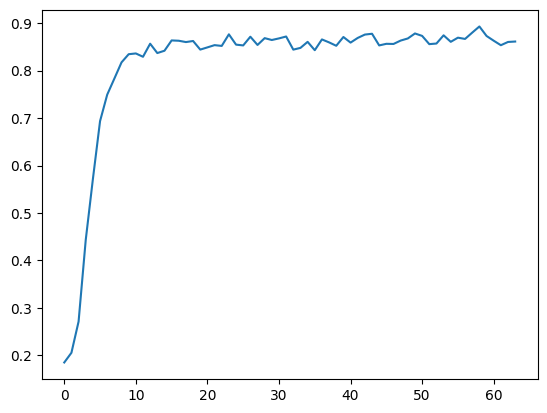

In [16]:
import matplotlib.pyplot as plt
@torch.no_grad
def calc_per_token_acc(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader):
    token_accuracies = []
    for x, y in data_loader:
        res, _ = model(x)
        _, predicted = torch.max(res, dim=-1)
        correct = (predicted == y)

        batch_accuracies = correct.float().mean(dim=0).cpu().numpy()
        token_accuracies.append(batch_accuracies)

    per_token_acc = np.mean(token_accuracies, axis=0)
    print(per_token_acc)
    return per_token_acc

per_token_acc = calc_per_token_acc(model, TEST_LOADER)
plt.plot(np.arange(per_token_acc.shape[0]), per_token_acc)
plt.show()